# Markov Chains

In this script, we try to make a distinction between SBH and LBH. We will look at the frequency of function types and compare them between the books.

In [1]:
import glob, re, getpass, collections, operator, scipy.stats, sklearn.metrics
from itertools import chain
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from discreteMarkovChain import markovChain
from functions.bhsa import get_data, unique, lbh_books, sbh_books # <- here's the new data data load statement -CK

from numpy.polynomial import Polynomial
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import pearsonr 
from scipy.spatial.distance import pdist
from scipy.stats import entropy
from numpy.linalg import norm
import math
from sklearn.cluster import DBSCAN

In [2]:
all_data = get_data()

# Functions

In [3]:
def transitionWalk1(clauses):
    states = list()
    for clause in clauses:
        states.append("Clause_Begin")
        states.extend(clause)
        states.append("Clause_End")
    return states

def transitionWalk2(clauses):
    return list(chain(*clauses))

def MarkovModel(transitionWalk):
    nodes = list(set(transitionWalk))
    transition_Matrix = np.zeros((len(nodes),len(nodes)))
    
    for i in range(0,len(transitionWalk)-1):
        transition_Matrix[nodes.index(transitionWalk[i]), nodes.index(transitionWalk[i+1])] +=1 
        
    df_Trans = pd.DataFrame(transition_Matrix, columns = nodes, index = nodes)    
    
     # Remove unused transition functions
    df_Trans = df_Trans[(df_Trans.T != 0).any()]
    df_Trans_Count = df_Trans.loc[:,(df_Trans != 0).any(axis=0)]
    
    df_Trans_Prob = df_Trans_Count.div(df_Trans_Count.sum(axis=1), axis=0) 
    
    return df_Trans_Count, df_Trans_Prob

def makeMarkovModels(df):
    df_Freq = dict()
    df_Prob = dict()
    
    for bookname, clauses in df.items():
        walk = transitionWalk1(clauses)
        df_Trans_Count, df_Trans_Prob = MarkovModel(walk)
        
        df_Freq[bookname] = df_Trans_Count
        df_Prob[bookname] = df_Trans_Prob
    return df_Freq, df_Prob

def MarkovChainSSP(df_Transition_prob, books):
    df_MC_SSP = pd.DataFrame()
    for bookname, transition in df_Transition_prob.items():

        P = np.matrix(transition.values)
        mc = markovChain(P)
        mc.computePi('linear') #We can also use 'power', 'krylov' or 'eigen', 'linear'
        
        dfSS = pd.DataFrame(list(mc.pi), index=transition.index, columns=[bookname])
        
        df_MC_SSP= pd.concat([dfSS,df_MC_SSP], axis=1)
        
    df_MC_SSP= df_MC_SSP.sort_index(axis=1)
    df_MC_SSP = df_MC_SSP.replace(np.nan,0.0)
    return df_MC_SSP   

def hellingerDistance(df_prob_M1,df_prob_M2):
    df1 = df_prob_M1.applymap(np.sqrt)
    df2 = df_prob_M2.applymap(np.sqrt)
    df_sub = df1.subtract(df2, fill_value=0)
    df_sub = df_sub.fillna(0.0)
    df_sub = np.power(df_sub, 2)
    sumDiff = np.sum(df_sub.values)
    helligerDistance = np.sqrt(sumDiff)/np.sqrt(2)
    return helligerDistance

def totalVariationDistance(df_prob_M1, df_prob_M2):
    df_sub = df_prob_M1.subtract(df_prob_M2, fill_value =0)
    df_sub = df_sub.fillna(0.0)
    maxVar = abs(df_sub.values).sum() *0.5
    return maxVar

def distanceMarkovTransitionMatrix(df_Prob, books):
    df_Dist = pd.DataFrame(np.zeros((len(books), len(books))), columns = books, index = books) 
    for indexi,i in enumerate(books):
        for indexj,j in enumerate(books):
            x = df_Prob[i]
            y = df_Prob[j]   
            df_Dist.loc[i,j] = totalVariationDistance(x,y)
    return df_Dist

def samplingClauses(df, sampleSize):
    new_df = dict()
    for bookname, clauses in df.items():
        n = math.ceil(len(clauses)*sampleSize / 2.) * 2 
        clauses_new = np.random.choice(clauses,n)
        new_df[bookname] = clauses_new
    return new_df
        
def validateModel(df, sampleSize):
    temp = samplingClauses(df, sampleSize)
    
    distance = dict()
    
    for bookname, clauses in temp.items():
        #print(bookname)
        clausesTrainTest = np.split(clauses, 2)
        train = clausesTrainTest[0]
        test = clausesTrainTest[1]
        
        #print("Train Walk")
        walk_train = transitionWalk1(train)
        #print("Train Model")
        a,model_train = MarkovModel(walk_train) 
        
        #print("Test Model")
        walk_test = transitionWalk1(test)
        #print("Test Model")
        a,model_test = MarkovModel(walk_test)
        
        #print("Distance Calculating")
        dist = totalVariationDistance(model_train, model_test)
        distance[bookname] = dist
        #print(dist)
    return distance



## Analysis

In [4]:
data = all_data['clause_types']
del data["sbh"]
del data["lbh"]
unique_functions = unique(otype='clause', feature='typ') # N.B., I've added back our excluded functions
print(unique_functions)
#data["Esther"][:1]

['NmCl', 'Way0', 'InfC', 'WayX', 'xYq0', 'Ptcp', 'WQt0', 'xQt0', 'ZIm0', 'xQtX', 'Ellp', 'WxY0', 'Voct', 'xYqX', 'WxQ0', 'XYqt', 'AjCl', 'XQtl', 'WXQt', 'WXYq', 'ZQt0', 'WQtX', 'CPen', 'ZYq0', 'WYq0', 'MSyn', 'WIm0', 'ZQtX', 'ZYqX', 'WxQX', 'WxYX', 'InfA', 'xIm0', 'WYqX', 'WxI0', 'WXIm', 'ZImX', 'XPos', 'XImp', 'Reop', 'WImX', 'xImX']


In [5]:
df_Freq, df_Prob = makeMarkovModels(data)
df_Prob["Esther"]

,WQt0,WXYq,ZYqX,xQtX,WxQ0,XQtl,Clause_End,Ellp,Clause_Begin,WYq0,...,WXIm,xQt0,ZIm0,ZQt0,Ptcp,AjCl,Way0,WxY0,xYq0,InfC
WQt0,0.100000,0.000000,0.000000,0.100000,0.100000,0.100000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000
WXYq,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.142857,0.000000
ZYqX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.200000,...,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000
xQtX,0.025000,0.025000,0.000000,0.025000,0.075000,0.025000,0.075000,0.025000,0.0,0.000000,...,0.000000,0.100000,0.000000,0.000000,0.100000,0.025000,0.075000,0.000000,0.000000,0.150000
WxQ0,0.000000,0.000000,0.000000,0.040000,0.120000,0.000000,0.000000,0.040000,0.0,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.080000
XQtl,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.071429,0.142857
Clause_End,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ellp,0.000000,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.258065,0.0,0.000000,...,0.000000,0.032258,0.000000,0.000000,0.096774,0.032258,0.032258,0.000000,0.000000,0.225806
Clause_Begin,0.000000,0.000000,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000
WYq0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000


In [6]:
MarkovSSP = MarkovChainSSP(df_Prob, data.keys())
#MarkovSSP

In [7]:
MarkovDistance = distanceMarkovTransitionMatrix(df_Prob, data.keys())
MarkovDistance

,Genesis,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Genesis,0.000000,18.709143,22.664257,20.501513,19.398026,17.948100,16.805161,17.114801,16.136121,17.645978,24.295378,24.225231,22.513183,21.522588,18.587896
Exodus,18.709143,0.000000,21.589934,19.401807,20.047930,19.550577,18.022507,19.533940,18.728492,20.671038,24.226580,24.161778,21.607058,21.773605,20.711121
Leviticus,22.664257,21.589934,0.000000,20.484987,22.526975,23.864762,22.353871,23.519684,22.846008,23.810702,24.894286,25.182790,23.527958,24.900899,24.635277
Deuteronomy,20.501513,19.401807,20.484987,0.000000,20.912283,22.168489,19.723793,21.155078,20.179712,20.992765,24.188853,23.164235,22.290396,22.618115,21.298670
Joshua,19.398026,20.047930,22.526975,20.912283,0.000000,20.821343,19.188986,19.673402,18.850931,19.350350,23.844156,22.448710,21.055689,21.748400,19.156347
Judges,17.948100,19.550577,23.864762,22.168489,20.821343,0.000000,17.314754,18.666064,17.673616,19.101934,24.410604,24.855387,23.053773,22.830723,19.802691
1_Samuel,16.805161,18.022507,22.353871,19.723793,19.188986,17.314754,0.000000,17.512728,17.407012,18.321343,23.274838,24.488179,21.681790,21.392483,19.280577
2_Samuel,17.114801,19.533940,23.519684,21.155078,19.673402,18.666064,17.512728,0.000000,17.723223,19.004860,24.341784,24.636936,21.816831,20.564317,19.670902
1_Kings,16.136121,18.728492,22.846008,20.179712,18.850931,17.673616,17.407012,17.723223,0.000000,17.072065,23.580248,23.609247,20.723034,20.957278,16.353242
2_Kings,17.645978,20.671038,23.810702,20.992765,19.350350,19.101934,18.321343,19.004860,17.072065,0.000000,23.949470,24.412331,21.229633,22.598646,18.988916


{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'r',
  'r',
  'c',
  'c',
  'b',
  'b',
  'b'],
 'dcoord': [[0.0, 23.059292406554025, 23.059292406554025, 0.0],
  [0.0, 24.831473004768075, 24.831473004768075, 23.059292406554025],
  [0.0, 25.457551130908211, 25.457551130908211, 24.831473004768075],
  [0.0, 26.520304853354332, 26.520304853354332, 25.457551130908211],
  [0.0, 26.815695500545345, 26.815695500545345, 26.520304853354332],
  [0.0, 27.359157331182942, 27.359157331182942, 0.0],
  [26.815695500545345,
   30.412660005100246,
   30.412660005100246,
   27.359157331182942],
  [0.0, 27.841483516836171, 27.841483516836171, 0.0],
  [0.0, 32.478624686542275, 32.478624686542275, 27.841483516836171],
  [0.0, 30.953428284021879, 30.953428284021879, 0.0],
  [0.0, 32.420327775606829, 32.420327775606829, 30.953428284021879],
  [0.0, 35.881067122541012, 35.881067122541012, 32.420327775606829],
  [32.478624686542275,
   40.661033744149648,
   40.661033744149648,
   35.8810671225

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


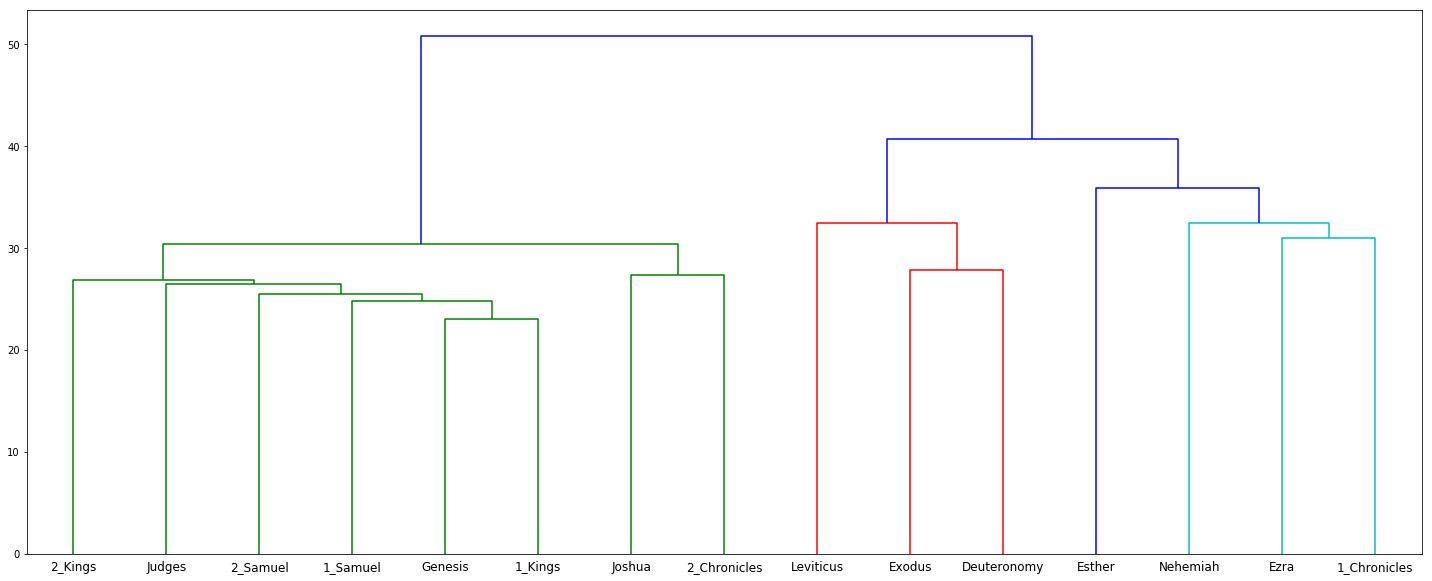

In [9]:
Z=linkage(np.matrix(MarkovDistance.values), 'ward')
#Z=linkage(np.matrix(MarkovSSP.values).transpose(), 'weighted', "correlation")
plt.figure(figsize=(25,10))
dendrogram(Z, labels=list(data.keys())) #
plt.show()

## DBSCAN

This does not look very promising

In [176]:
db = DBSCAN(eps = 3, min_samples=1, metric="precomputed")
y_db = db.fit_predict(MarkovDistance)
df_cluster = pd.DataFrame([data.keys(),y_db]).transpose()
df_cluster.columns = ['Book', 'Cluster']
df_cluster["Group"] = ['sbh' if x in list(sbh_books) else 'lbh' for x in df_cluster['Book']]
df_cluster

,Book,Cluster,Group
0,Genesis,0,sbh
1,sbh,0,lbh
2,Exodus,0,sbh
3,Leviticus,1,sbh
4,Deuteronomy,0,sbh
5,Joshua,0,sbh
6,Judges,0,sbh
7,1_Samuel,0,sbh
8,2_Samuel,0,sbh
9,1_Kings,0,sbh


# Validating Model

In [32]:
df_validation = pd.DataFrame()
for sampleSize in [1000]:
    print(sampleSize)
    random = pd.DataFrame(columns = list(data.keys()))
    for i in range(0,1):
        if(i == 25):
            print("25%")
        if(i == 50):
            print("50%")
        if(i == 75):
            print("75%")
        results = validateModel(data, sampleSize)
        res = pd.DataFrame(results,index=[i])
        random = random.append(res)    
    df_validation[sampleSize] = random.mean(0)
df_validation = df_validation.transpose()
df_validation

1000


,1_Chronicles,1_Kings,1_Samuel,2_Chronicles,2_Kings,2_Samuel,Deuteronomy,Esther,Exodus,Ezra,Genesis,Joshua,Judges,Leviticus,Nehemiah,lbh,sbh
1000,0.02396,0.036331,0.024551,0.029056,0.034635,0.031872,0.029651,0.040563,0.022658,0.033393,0.035171,0.019562,0.025991,0.033149,0.030775,0.029531,0.022357


## Helliger distance

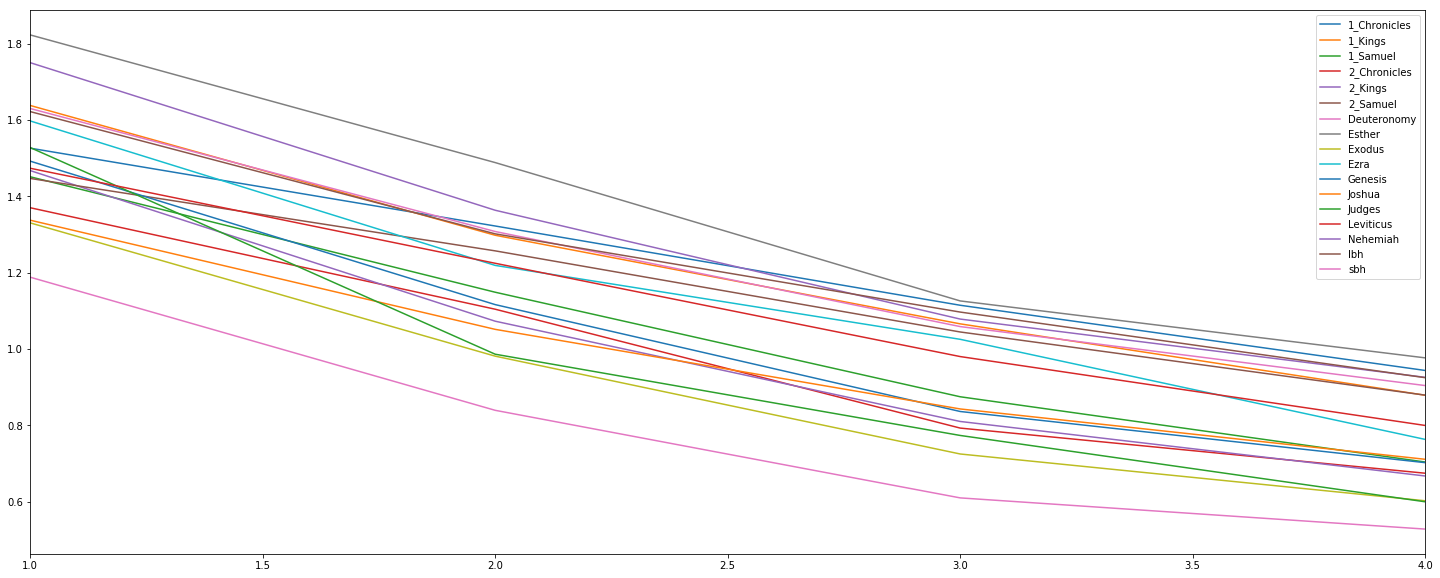

In [29]:
plt.figure(figsize = (25,10))
df_validation.plot(figsize  = (25,10))
plt.show()

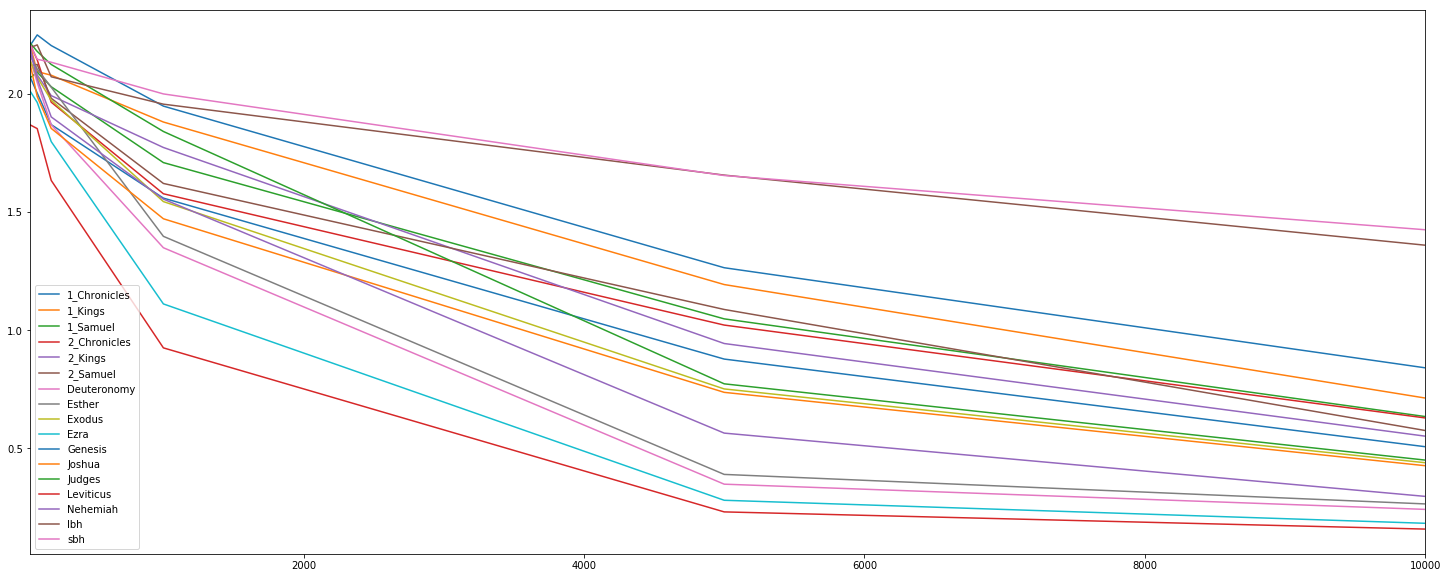

In [16]:
plt.figure(figsize = (25,10))
df_validation.plot(figsize  = (25,10))
plt.show()

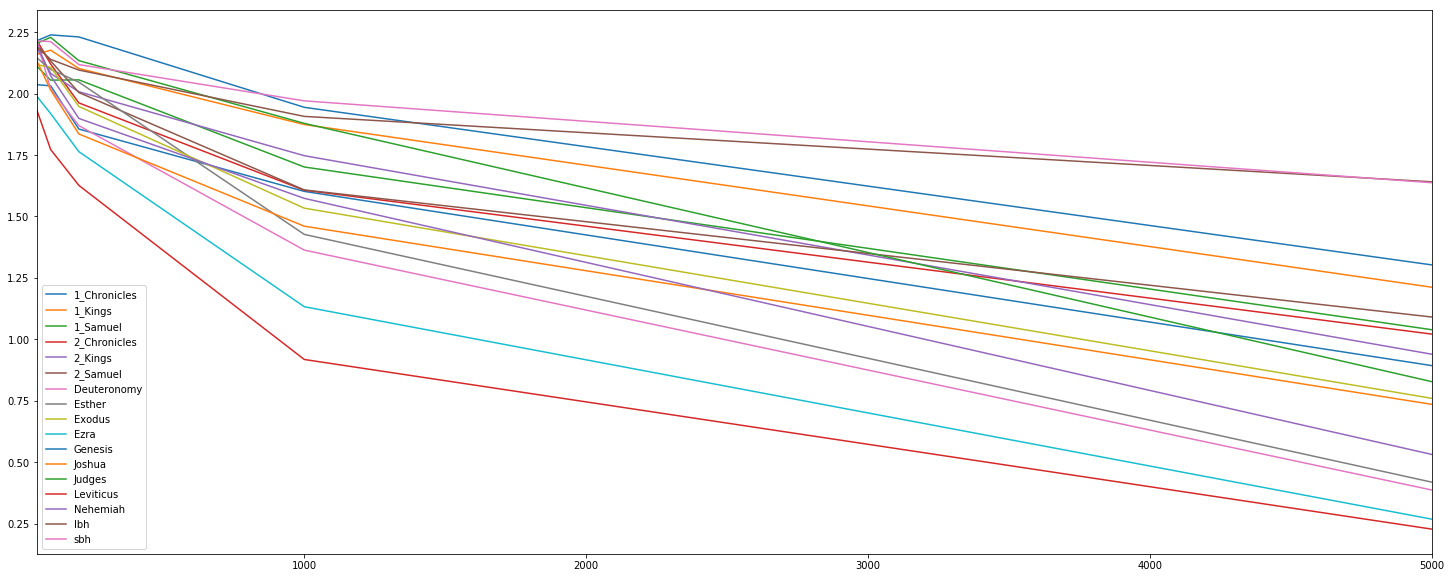

In [14]:
plt.figure(figsize = (25,10))
df_validation.plot(figsize  = (25,10))
plt.show()

## Total variation distance

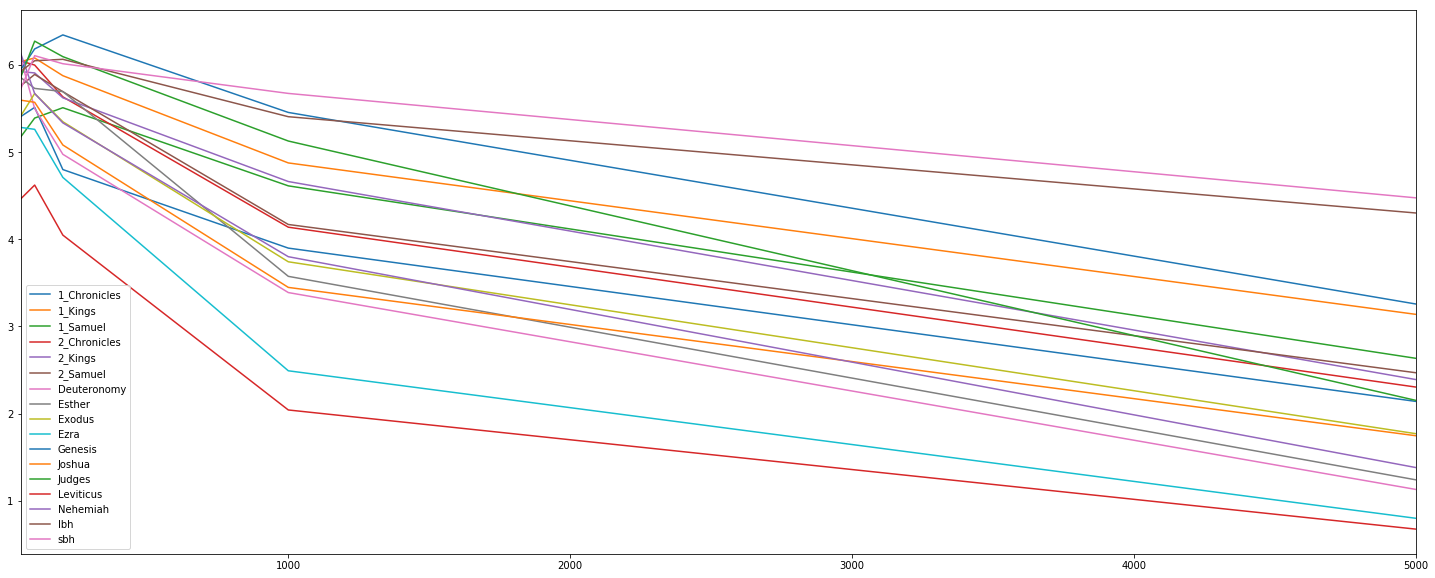

In [11]:
plt.figure(figsize = (25,10))
df_validation.plot(figsize  = (25,10))
plt.show()